<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

##Imports

In [1]:
import numpy as np
from numpy import arange
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
from math import ceil
import keras
import tensorflow as tf
from tensorflow import norm
from tensorflow.math import reduce_mean, abs
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.initializers import RandomNormal, Zeros, Constant
from pylab import cm,imshow,contour,clabel,colorbar

In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



##Preparing the data

###Defining the control points

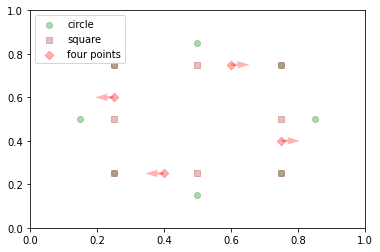

In [3]:
np.random.seed(1)
square = np.array([
                   [0.25,0.25],
                   [0.5,0.25],
                   [0.75,0.25],
                   [0.75,0.5],
                   [0.75,0.75],
                   [0.5,0.75],
                   [0.25,0.75],
                   [0.25,0.5]
                   ])
circle = np.array([
                   [0.25,0.25],
                   [0.5,0.15],
                   [0.75,0.25],
                   [0.85,0.5],
                   [0.75,0.75],
                   [0.5,0.85],
                   [0.25,0.75],
                   [0.15,0.5]
                   ])
fourPoints = np.array([
                   [0.4,0.25],
                   [0.75,0.4],
                   [0.6,0.75],
                   [0.25,0.6],
                   ])
foruPointsNormals = np.array([
                   [-1.0,0.0],
                   [1.0,0.0],
                   [1.0,0.0],
                   [-1.0,0.0],
                   ])
plt.scatter(circle[:,0], circle[:,1], c='green', marker='o', label='circle', alpha=0.3)
plt.scatter(square[:,0], square[:,1], c='brown', marker='s', label='square', alpha=0.3)
plt.scatter(fourPoints[:,0], fourPoints[:,1], c='red', marker='D', label='four points', alpha=0.3)
plt.quiver(fourPoints[:,0], fourPoints[:,1], foruPointsNormals[:,0], foruPointsNormals[:,1], color='red', alpha=0.3)
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

###Defining training data generator

In [4]:
class DataGenerator(Sequence):
  seed = 0
  def __init__(self, batchCount, batchSize, controlPoints, controlNormals=None):
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.batchCount = batchCount
    self.batchSize = batchSize
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return self.batchCount

  def __getitem__(self, idx):
    P = []
    for i in range(self.batchSize):
      p = self.randGen.random(2)
      P.append(p)
    return np.array(P), self.controlPoints, controlNormals

  #def on_epoch_end(self):
    #self.randGen = np.random.default_rng(seed=self.seed)

##Creating model

In [5]:
class CustomModel(Model):
  def __init__(self, *args, **kwargs):
    Model.__init__(self, *args, **kwargs)
    self.eikonalLambda = 0.1
    self.normalLambda = 1
    self.initialWeights = self.get_weights()

  def train_step(self, data):
    volumePoints, surfacePoints, surfaceNormals = data
    trainableVariables = self.trainable_variables

    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)

      #Volume-eikonal
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(volumePoints)
        volumePred = self(volumePoints, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
      eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

      #Surface
      with tf.GradientTape() as surfaceTape:
        surfaceTape.watch(surfacePoints)
        surfacePred = self(surfacePoints, training=True)
      surfaceAbs = abs(surfacePred)
      if surfaceNormals is not None:
        surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
        surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
      surfaceLoss = reduce_mean(surfaceAbs)

      loss = surfaceLoss + self.eikonalLambda * eikonalLoss

    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    volumePoints, surfacePoints, surfaceNormals = data

    #Volume-eikonal
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(volumePoints)
      volumePred = self(volumePoints, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
    eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

    #Surface
    with tf.GradientTape() as surfaceTape:
      surfaceTape.watch(surfacePoints)
      surfacePred = self(surfacePoints, training=True)
    surfaceAbs = abs(surfacePred)
    if surfaceNormals is not None:
      surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
      surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
    surfaceLoss = reduce_mean(surfaceAbs)

    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    return {"loss": loss}
  
  def reset(self):
    self.set_weights(self.initialWeights)

Trainable variables: 357


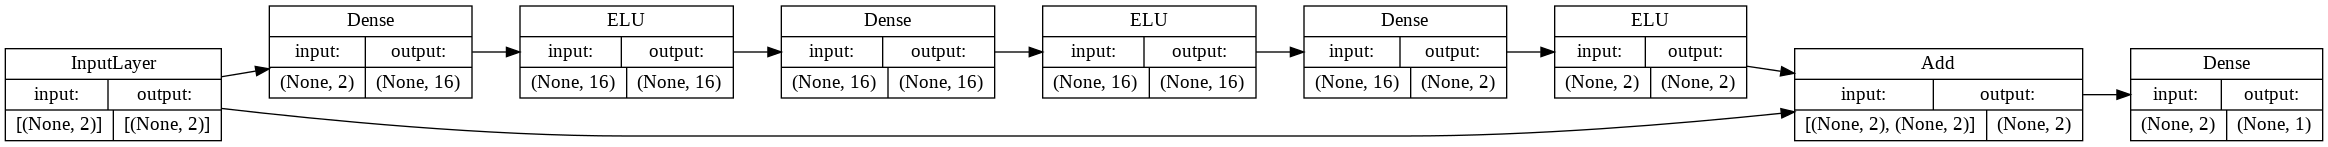

In [6]:
inputLayer = Input(shape=(2,))
hiddenLayer1 = Dense(16,
                     kernel_initializer=RandomNormal(stddev=np.sqrt(2)/np.sqrt(16)),
                     bias_initializer=Zeros())(inputLayer)
elu1 = tf.keras.layers.ELU(0.8)(hiddenLayer1)
hiddenLayer2 = Dense(16,
                     kernel_initializer=RandomNormal(stddev=np.sqrt(2)/np.sqrt(16)),
                     bias_initializer=Zeros())(elu1)
elu2 = tf.keras.layers.ELU(0.8)(hiddenLayer2)
#dropout1 = Dropout(0.1)(hiddenLayer2)
hiddenLayer3 = Dense(2,
                     kernel_initializer=RandomNormal(stddev=np.sqrt(2)/np.sqrt(2)),
                     bias_initializer=Zeros())(elu2)
elu3 = tf.keras.layers.ELU(0.9)(hiddenLayer3)
skipLayer = Add()([elu3, inputLayer])
outputLayer = Dense(1,
                    activation='linear',
                    kernel_initializer= RandomNormal(mean=np.pi/np.sqrt(2), stddev=0.00001),
                    bias_initializer=Constant(-0.5)
                    )(skipLayer)

model = CustomModel(inputs = inputLayer, outputs = outputLayer)
model.compile(optimizer = Adam(lr = 0.0015))
#model.summary()
print(f'Trainable variables: {np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])}')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

##Feedback

In [7]:
def plot(model, controlPoints=None, controlNormals=None, plotSize='big'):
    sizeDict = {
        'big': ((13,10), 200, 0.05),
        'medium': ((8,5), 100, 0.1),
        'small': ((4,3), 40, 0.2),
    }
    figSize, resolution, lineDensity = sizeDict[plotSize]
    plt.figure(figsize=figSize)
    grid = np.empty((resolution*resolution,2))
    for y in range(resolution):
      for x in range(resolution):
        grid[y*resolution+x] = [x/resolution, y/resolution]
    prediction = np.array(model.predict(grid).reshape((resolution,resolution)))
    grid = []

    max = np.max(prediction)
    min = np.min(prediction)
    if (abs(min) > max):
      max = abs(min)
    im = imshow(prediction,
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                origin='lower',
                norm = colors.Normalize(vmin=-max, vmax=max))
    plt.axis('off')
    colorbar(im)
    cset = contour(prediction,arange(-0.6,0.6,lineDensity),linewidths=2,cmap='gray_r')
    clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
    if controlPoints is not None:
      plot = sns.scatterplot(x=controlPoints[:,0]*resolution,
                      y=controlPoints[:,1]*resolution,
                      color = 'grey',
                      s = 80,
                      linewidth = 0)
      if controlNormals is not None:
        plt.quiver(controlPoints[:,0]*resolution,
                  controlPoints[:,1]*resolution,
                  controlNormals[:,0],
                  controlNormals[:,1],
                  color='grey',
                  headlength = 3,
                  scale = 15,
                  headaxislength=3)
    prediction = []
    plt.show()

class PlotCallback(Callback):
  def __init__(self, model, controlPoints=None, controlNormals=None, step=2):
    self.model = model
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.step = step
    self.plots = []

  def on_train_begin(self, logs=None):
    print('Initial weights')
    plot(self.model, controlPoints, controlNormals, plotSize='medium')

  def on_epoch_end(self, epoch, logs=None):
    if (epoch%self.step == 0):
      plot(self.model, controlPoints, controlNormals, plotSize='small')

##Train

Initial weights


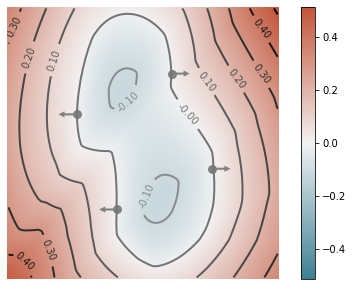

Epoch 1/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0178


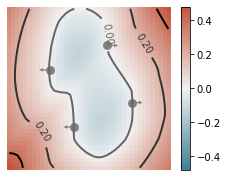

Epoch 2/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0168


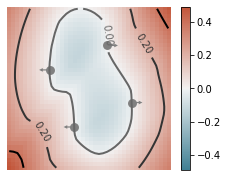

Epoch 3/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0164


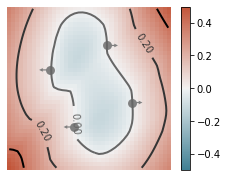

Epoch 4/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0164


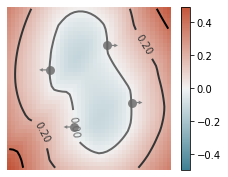

Epoch 5/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0162


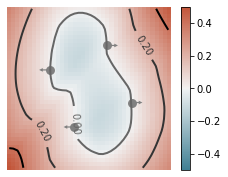

Epoch 6/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0150


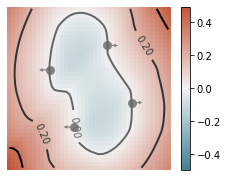

Epoch 7/10
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0149


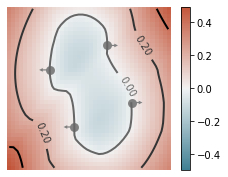

Epoch 8/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0146


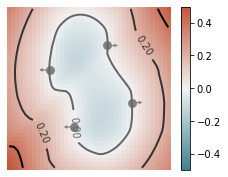

Epoch 9/10
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0140


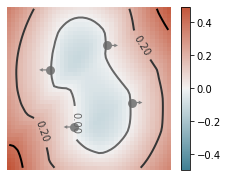

Epoch 10/10
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0139


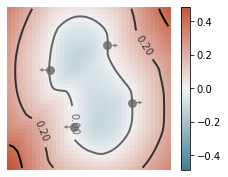

In [10]:
controlPoints = fourPoints
controlNormals = foruPointsNormals
#model.reset()
history = model.fit(DataGenerator(batchCount = 10000,
                                  batchSize = 4,
                                  controlPoints = controlPoints,
                                  controlNormals = controlNormals),
                    verbose = 1,
                    callbacks = [PlotCallback(model, controlPoints, controlNormals, 1)],
                    epochs = 10)

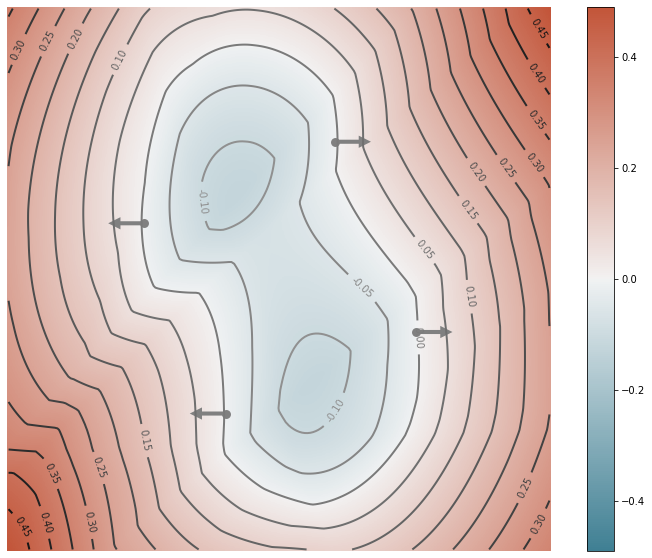

In [11]:
plot(model, controlPoints, controlNormals)

In [12]:
model.save_weights("./weights")